# IONQ in Focus: Predicting the Future of Quantum Tech Stocks



Author: [Hongrui Wang]

Course Project, UC Irvine, Math 10, Spring 25

I would like to post my notebook on the course's website. [Yes]

# 1. Introduction
The purpose of this project is to forecast the price of IONQ stock. I chose IONQ because it is the stock I chose in the stock competition to go up in the future. The following dataset contains historical stock price data for IONQ from 2024.1.1 to 2025.5.1. I will analyze the data and build a model for stock price prediction through feature engineering, linear regression, and model evaluation.

# 2. Import data
I import all the necessary libraries for data analysis, visualization, and building a linear regression model, then use yfinance to download historical stock data for IONQ from January 1, 2024, to May 26, 2025, and display the first few rows to check the dataset.










In [1]:

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor


In [2]:
data = yf.download("IONQ", start="2024-01-01", end="2025-05-26")
print(data.head())


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

Price       Close   High     Low   Open   Volume
Ticker       IONQ   IONQ    IONQ   IONQ     IONQ
Date                                            
2024-01-02  12.16  12.59  12.100  12.35  5951100
2024-01-03  11.93  12.09  11.770  11.81  6225700
2024-01-04  12.28  12.61  11.850  12.06  7264400
2024-01-05  12.00  12.38  11.950  12.09  6100000
2024-01-08  12.64  12.73  12.025  12.12  6044300


## Cleaning data
I make a copy of the original dataset, remove all rows with missing values, and rename several columns (like 'Open' to 'Opening Price') to make the dataset cleaner and more readable.

In [3]:
data = data.copy()
data.dropna(inplace=True)
data.rename(columns={'Open': 'Opening Price',
                    'High': 'Highest Price',
                    'Low': 'Lowest Price',
                    'Close': 'Closing Price'},
                    inplace=True)
data.head()

Price      Closing Price Highest Price Lowest Price Opening Price   Volume
Ticker              IONQ          IONQ         IONQ          IONQ     IONQ
Date                                                                      
2024-01-02         12.16         12.59       12.100         12.35  5951100
2024-01-03         11.93         12.09       11.770         11.81  6225700
2024-01-04         12.28         12.61       11.850         12.06  7264400
2024-01-05         12.00         12.38       11.950         12.09  6100000
2024-01-08         12.64         12.73       12.025         12.12  6044300

## Describe
I use data.describe() to get summary statistics (like mean, standard deviation, min, and max) for the numerical columns, and data.info() to check the overall structure of the dataset, including the number of entries, column types, and whether there are any missing values.

In [4]:
print(data.describe())
print(data.info())


Price  Closing Price Highest Price Lowest Price Opening Price        Volume
Ticker          IONQ          IONQ         IONQ          IONQ          IONQ
count     350.000000    350.000000   350.000000    350.000000  3.500000e+02
mean       18.027314     18.889446    17.092691     17.907497  1.426960e+07
std        12.145853     12.892214    11.266028     11.946832  1.465106e+07
min         6.570000      6.765000     6.220000      6.270000  2.062300e+06
25%         8.220000      8.466250     7.992500      8.222500  4.768775e+06
50%        10.915000     11.275000    10.700000     11.085000  8.196450e+06
75%        27.439999     28.467499    25.785750     27.775000  1.988050e+07
max        51.070000     54.740002    48.730000     51.279999  1.283438e+08
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 350 entries, 2024-01-02 to 2025-05-23
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   (Closing

# 3.  Visualizing
## 1）Line graph
I create a line plot of the IONQ stock’s closing prices to more clearly see the stock’s overall trend over time, setting the figure size, adding a title and axis labels, enabling the grid, and displaying the plot for better visualization.

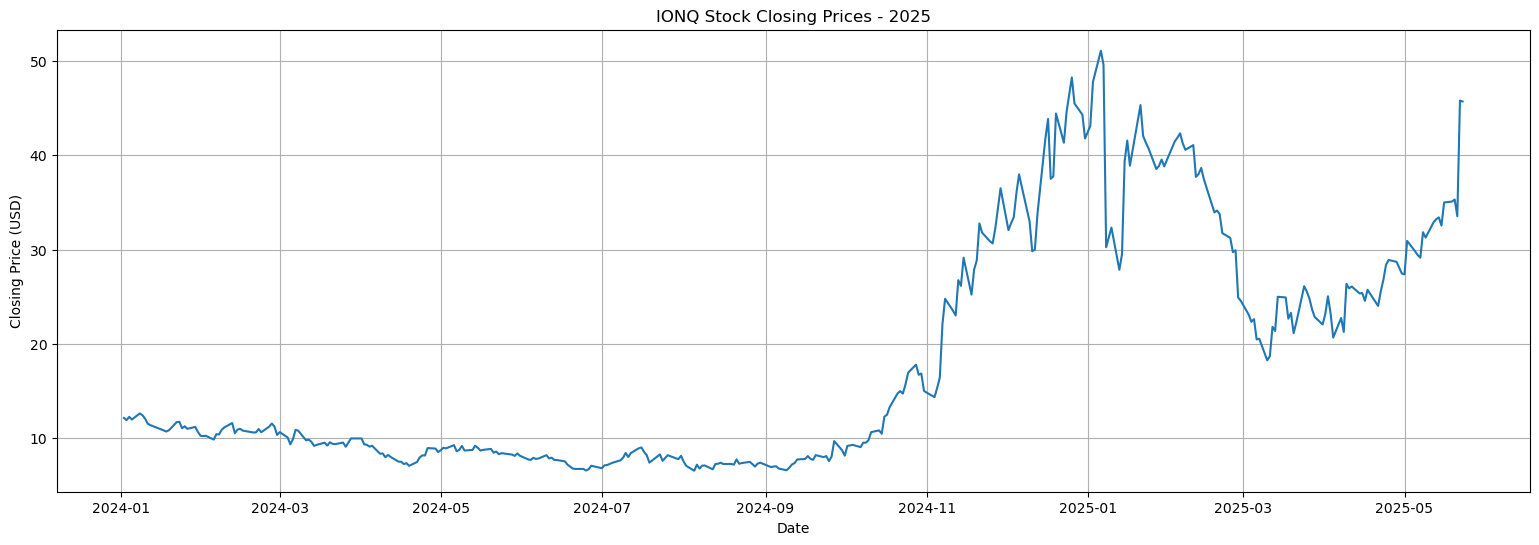

In [5]:
closing_prices = data['Closing Price']

plt.figure(figsize=(19, 6))
plt.plot(closing_prices)
plt.title("IONQ Stock Closing Prices - 2025")
plt.xlabel("Date")
plt.ylabel("Closing Price (USD)")
plt.grid(True)
plt.show()

## 2）Correlation heatmap
I used a correlation heatmap to see how strongly the features are related. we can find all price-related features showed very high positive correlation, while volume had a weaker correlation with prices. \
\
The range of correlation coefficients are between -1 to 1, -1 means negative correlation, 0 means no correlation, and 1 means positive correlation

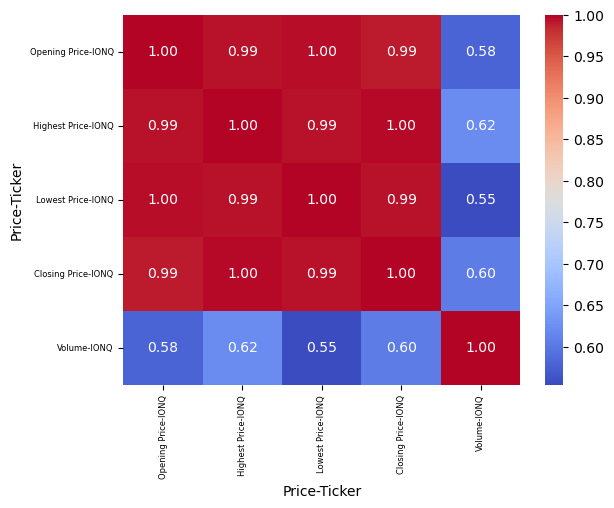

In [6]:
corr = data[['Opening Price', 'Highest Price', 'Lowest Price', 'Closing Price', 'Volume']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.xticks(fontsize = 6)
plt.yticks(fontsize = 6)
plt.show()

## 3）Pairplot
The pairplot helped me visualize these relationships and confirmed that the price features follow clear linear trends, making them suitable for linear regression.

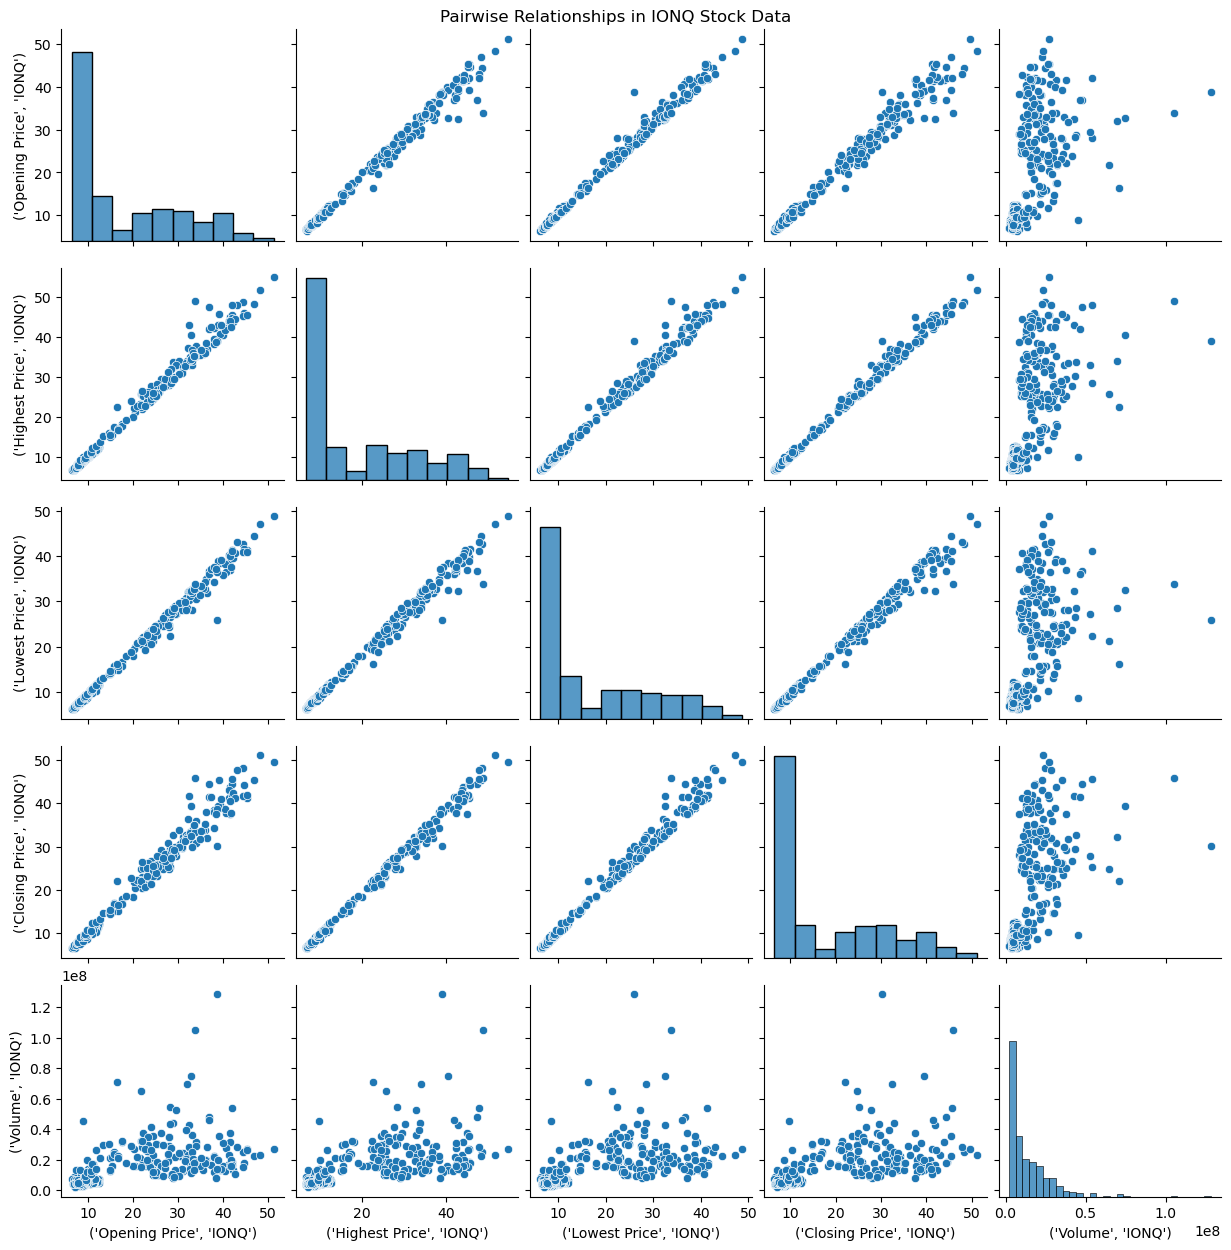

In [7]:
selected_columns = ['Opening Price', 'Highest Price', 'Lowest Price', 'Closing Price', 'Volume']
sns.pairplot(data[selected_columns])
plt.suptitle("Pairwise Relationships in IONQ Stock Data", y = 1)
plt.show()

# 4. Linear regression
linear regression is a model that estimates the relationship between a scalar response (dependent variable) and one or more explanatory variables.\
\
It predicts the output by finding the best-fitting line that minimizes the difference between actual and predicted values.\
\
We find lag price and moving average, it enhances the predictive power of a linear regression model when forecasting stock prices. Lag features allow the model to account for temporal dependencies by including past closing prices, which are often strong indicators of future price movements. Moving averages can help smooth out short-term volatility and reveal underlying trends in the data. Without these time-based features, the model relies solely on current-day information and may fail to capture the sequential patterns that are essential for accurate stock market prediction.

## Create model

In [8]:
# Create lag features
data['Lag1'] = data['Closing Price'].shift(1)
data['Lag2'] = data['Closing Price'].shift(2)
data['Lag3'] = data[ 'Closing Price'].shift(3)

# Create moving average
data ['MA5'] = data ['Closing Price'].rolling(window=5).mean()
data ['MA10'] = data ['Closing Price'].rolling(window=10).mean()
data = data.dropna()

# Define features and target
X = data[['Lag1', 'Lag2', 'Lag3', 'MA5', 'MA10']]
y = data[ 'Closing Price']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print("Mean Squared Error:", mse) 
print("R^2 Score:", r2)
print(f"Mean Absolute Error (MAE): {mae:.4f}")

Mean Squared Error: 1.4899574342191144
R^2 Score: 0.9518347432114455
Mean Absolute Error (MAE): 0.9445


## Visualizing

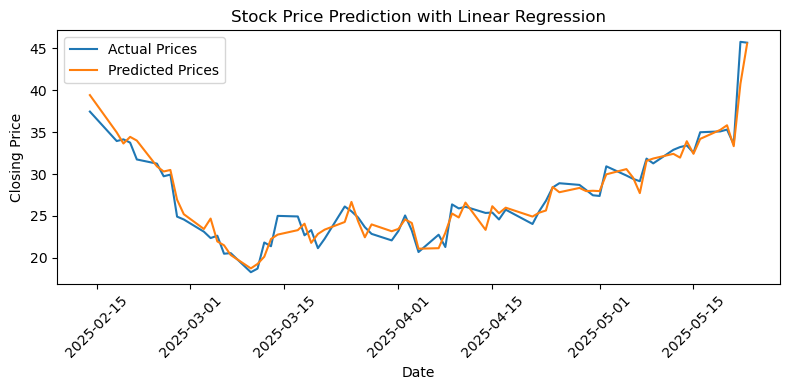

In [9]:
# Draw diagram
x_dates = y_test.index
plt.figure(figsize=(8, 4))
plt.plot(x_dates, y_test.values, label='Actual Prices')
plt.plot(x_dates, y_pred, label='Predicted Prices') 
plt.title('Stock Price Prediction with Linear Regression') 
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

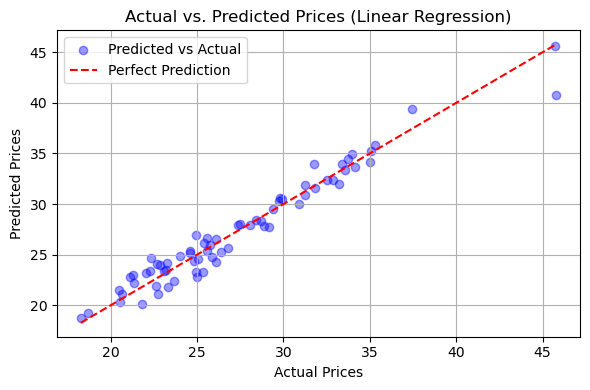

In [10]:
plt.figure(figsize=(6, 4))
plt.scatter(y_test, y_pred, alpha=0.4, color='blue',
            label='Predicted vs Actual')
plt.plot([y_test.min(), y_test.max()],[y_test.min(), y_test.max()],color='red', linestyle='--', label='Perfect Prediction')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs. Predicted Prices (Linear Regression)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Predict for future
This code is used to predict the stock price in the next five days. It generates features based on the current data, uses the trained model to gradually predict the closing price of each day, and updates the input data for the next prediction, thereby achieving multi-step rolling prediction.

In [11]:
from collections import deque

n_days = 5
future_predictions = []

recent_prices = deque(data['Closing Price'].values[-10:], maxlen=10) 
latest_data = data.iloc[-1]
for _ in range(n_days):
    features = latest_data[['Lag1', 'Lag2', 'Lag3', 'MA5', 'MA10']].values.reshape(1, -1)
    pred = model.predict(features)[0]
    future_predictions.append(pred)
    new_row = latest_data.copy()
    new_row['Lag3'] = new_row['Lag2']
    new_row['Lag2'] = new_row['Lag1']
    new_row['Lag1'] = pred
    float(np.mean(list(recent_prices)[-5:])), 
    float(np.mean(recent_prices))  
    latest_data = new_row
future_predictions

[array([45.59288915]),
 array([40.58337457]),
 array([29.57693903]),
 array([34.19327268]),
 array([44.41969461])]

## Conclusion
The linear regression model demonstrates strong predictive performance in forecasting stock prices. With a low mean squared error (MSE) of 1.49 and a mean absolute error (MAE) of 0.9445, the model's predictions are closely aligned with the actual values. Furthermore, the high R-squared value of 0.9518 indicates that the model explains approximately 95.18% of the variance in the target variable. These metrics collectively suggest that the model is highly effective and well-suited for the given data.\
\
These results indicate that the model is successful.


# 5. Tree-Based Regression Models

In addition to linear regression, I explored tree-based regression models to improve prediction performance and capture potential nonlinear relationships in the stock data.

Tree-based models do not require assumptions about the underlying data distribution or linearity. Instead, they split the data into decision rules based on feature values, allowing them to model complex patterns and interactions.

In this project, I used a Random Forest Regressor, which is an ensemble method that builds multiple decision trees and averages their predictions. This approach helps reduce overfitting and improves generalization compared to a single decision tree.

The following sections present the implementation and evaluation of the tree-based model using cross-validation.


In [12]:
! pip install scikit-learn xgboost lightgbm


## Create model

In [13]:
X = data[['Lag1', 'Lag2', 'Lag3', 'MA5', 'MA10']]
y = data['Closing Price'].to_numpy().ravel()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

model_2 = RandomForestRegressor(n_estimators=100, random_state=42)
model_2.fit(X_train, y_train)

y_pred = model_2.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Mean Squared Error:", mse)
print("R^2 Score:", r2)
print(f"Mean Absolute Error (MAE): {mae:.4f}")

Mean Squared Error: 12.107833043109688
R^2 Score: 0.6085949341365131
Mean Absolute Error (MAE): 2.8224


## Visualizing

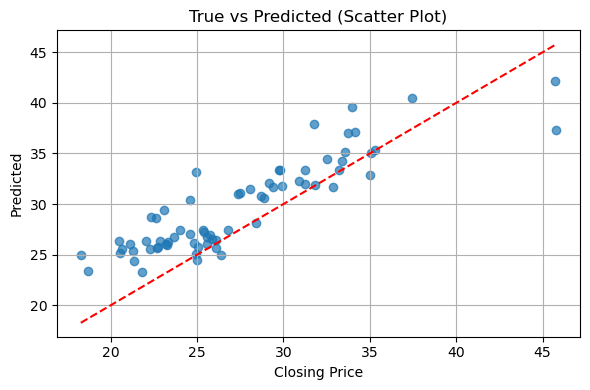

In [14]:
plt.figure(figsize=(6,4))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--') 
plt.title('True vs Predicted (Scatter Plot)')
plt.xlabel('Closing Price')
plt.ylabel('Predicted')
plt.grid(True)
plt.tight_layout()
plt.show()


## Conclusion
This study applied a Random Forest regression model to predict the closing price of IONQ stocks using lag features (Lag1–Lag3) and moving averages (MA5, MA10).\
\
The model achieved an R² score of 0.61, indicating moderate ability to explain price variations. The MAE of 2.82 and MSE of 12.11 suggest noticeable prediction errors. The scatter plot shows that predicted values deviate from the ideal diagonal, especially at higher price levels.\
\
Overall, while the model shows potential, its performance could be improved by including more informative features or tuning model parameters.




# 6. Cross Validation for linear and tree based
Cross-validation is a technique used to evaluate the performance and generalizability of a machine learning model on unseen data. It helps you avoid overfitting and gives you a more reliable estimate of how well your model will perform in the real world.


## 1）linear regression 

In [15]:
model = LinearRegression()
scores = cross_val_score(model, X, y, cv=5, scoring='r2') 
print("Cross-validated R^2 scores:", scores)
print("Average R^2 score:", scores.mean())

mae_scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_absolute_error')
print("MAE per fold:", -mae_scores)
print("Average MAE:", -mae_scores.mean())

mse_scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
print("MSE per fold:", -mse_scores)
print("Average MSE:", -mse_scores.mean())

Cross-validated R^2 scores: [0.94092907 0.87633618 0.98570726 0.86650019 0.95163048]
Average R^2 score: 0.9242206382600383
MAE per fold: [0.23165961 0.19841167 0.26873789 1.81630581 0.92365185]
Average MAE: 0.6877533662929997
MSE per fold: [0.08605478 0.05900285 0.14762031 6.9564641  1.44528434]
Average MSE: 1.7388852769820762


## 2）Tree based

In [16]:
model = RandomForestRegressor()
scores = cross_val_score(model, X, y, cv=5, scoring='r2') 
print("Cross-validated R^2 scores:", scores)
print("Average R^2 score:", scores.mean())

mae_scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_absolute_error')
print("MAE per fold:", -mae_scores)
print("Average MAE:", -mae_scores.mean())

mse_scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
print("MSE per fold:", -mse_scores)
print("Average MSE:", -mse_scores.mean())

Cross-validated R^2 scores: [0.00890599 0.79296087 0.85143157 0.6469417  0.617109  ]
Average R^2 score: 0.5834698264015312
MAE per fold: [1.17354211 0.23266321 0.72862067 3.21907968 2.94603969]
Average MAE: 1.6599890712468117
MSE per fold: [ 1.82720444  0.10337599  1.5563836  21.47015148 11.5589537 ]
Average MSE: 7.303213839786902


## 3）Conclusion
In cross-validation, Linear Regression significantly outperformed the Random Forest model. It achieved higher average R², and lower MAE and MSE. The Random Forest model showed large variance in performance across folds, with some R² scores even negative, indicating poor generalization. This suggests that for this dataset, linear relationships dominate, and simpler models like Linear Regression are more suitable.



# 7. ARIMA Model

ARIMA models are mainly used for time series forecasting, that is, to predict future trends or values based on past data.\
ARIMA model works well on non-stationary data.

Components:
1. AutoRegressive
2. Moving Average
3. Integrated

Notation: ARIMA(p,d,q), p is number of AR terms, d = number of times the data is differenced to achieve stationarity, q is number of MA terms\
\
d: Look at the trend. If the data is not stable (up or down), take differences until it looks flat — the number of times you do this is d.\
p: Check the PACF plot to find p.\
q: Check the ACF plot to find q.\
\
The normal steps for judging the ARIMA model are to first use the ADF test to determine whether the data is stationary. If it is not stationary, the data is differentiated. Then use the ACF test to determine q and the PACF test to determine p. Here, I use python to directly help me find the most suitable ARIMA model

## Choose model
We use the IONQ stock as an example.


In [17]:
! pip install pmdarima

In [18]:
from pmdarima.arima import auto_arima
model = auto_arima(data['Closing Price'], seasonal=False, trace=True)


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1448.891, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1455.443, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1456.616, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1456.466, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1454.290, Time=0.00 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1453.482, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1453.012, Time=0.05 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1445.653, Time=0.09 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1452.809, Time=0.05 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=1446.378, Time=0.12 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=1446.664, Time=0.20 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=1445.146, Time=0.12 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1454.780, Time=0.06 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=1447.958, Time=0.09 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept

In [19]:
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  341
Model:               SARIMAX(2, 1, 3)   Log Likelihood                -716.226
Date:                Tue, 10 Jun 2025   AIC                           1444.451
Time:                        23:10:26   BIC                           1467.425
Sample:                             0   HQIC                          1453.605
                                - 341                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0849      0.066     16.406      0.000       0.955       1.215
ar.L2         -0.9163      0.055    -16.812      0.000      -1.023      -0.809
ma.L1         -1.1761      0.077    -15.366      0.0

This code uses the ARIMA(2,1,3) model to conduct daily rolling predictions on the closing prices of stocks. By dividing the data into the training set and the test set, and fitting the model with historical data at each step to predict the next value, and then adding the true value to the history for further prediction, the mean square error (MSE) and the coefficient of determination (R²) of the model are finally calculated. To evaluate the prediction effect.


In [20]:
from statsmodels.tsa.arima.model import ARIMA
import numpy as np

def arima_forecast(history):
    model = ARIMA(history, order=(2,1,3))
    model_fit = model.fit()
    
    output = model_fit.forecast()
    yhat = output[0]
    return yhat

X = closing_prices.values
size = int(len(X) * 0.8)
train, test = X[0:size], X[size:len(X)]

history = [x for x in train]
predictions = list()
for t in range(len(test)):
    yhat = arima_forecast(history)
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
mse = mean_squared_error(test, predictions)
print(f"Mean Squared Error (MSE): {mse:.4f}")
r2 = r2_score(test, predictions)
print(f"R-squared (R²): {r2:.4f}")
mae = mean_absolute_error(test, predictions)
print(f"Mean Absolute Error (MAE): {mae:.4f}")

Mean Squared Error (MSE): 5.1380
R-squared (R²): 0.8408
Mean Absolute Error (MAE): 1.4483


## Visualizing

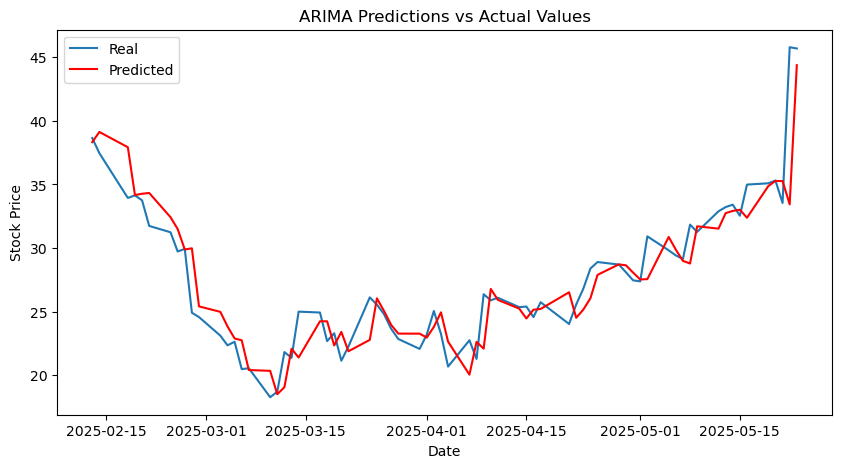

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5), dpi=100)
plt.plot(closing_prices.iloc[size:,:].index, test, label='Real')
plt.plot(closing_prices.iloc[size:,:].index, predictions, color='red', label='Predicted')
plt.title('ARIMA Predictions vs Actual Values')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

## Predict for future

In [22]:
model = ARIMA(closing_prices, order=(2,1,3))
result = model.fit()
forecast_steps = 5
forecast = result.forecast(steps=forecast_steps)
print("Future predictions:")
print(forecast)

Future predictions:
350    45.197194
351    44.306404
352    43.641951
353    43.737226
354    44.449449
Name: predicted_mean, dtype: float64


/Users/wanghongrui/anaconda3/envs/math9/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/wanghongrui/anaconda3/envs/math9/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/wanghongrui/anaconda3/envs/math9/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/wanghongrui/anaconda3/envs/math9/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Predicti

## Conclusion
The ARIMA(2,1,3) model demonstrates reasonably strong predictive capability in forecasting stock closing prices. With a mean squared error (MSE) of 5.1380 and a mean absolute error (MAE) of 1.4483, the model maintains a moderate level of accuracy. Additionally, the R-squared value of 0.8408 indicates that the model can explain approximately 84% of the variance in stock prices. \
\
Although it is not the most accurate among all models, ARIMA(2,1,3) still serves as a reliable and interpretable approach for time series forecasting.



# 8. Reflection
In this project, I aimed to forecast the stock price of IONQ using three different modeling approaches: Linear Regression, Random Forest Regression, and ARIMA. I engineered lag-based and moving average features from historical data and evaluated model performance using both a train-test split and 5-fold cross-validation to ensure reliability and robustness.\
\
The Linear Regression model delivered the strongest and most consistent results. It achieved a high R² score of 0.9518 on the test set and an average R² score of 0.8877 across cross-validation folds. Its errors were relatively low, with an average mean absolute error (MAE) of 0.6846 and mean squared error (MSE) of 1.71, indicating strong predictive accuracy.\
\
The ARIMA model, which is well-suited for time series data, performed moderately well, with a test set R² of 0.8408, MSE of 5.14, and MAE of 1.45. Although it captured temporal dynamics, it lagged behind linear regression in predictive precision.\
\
In contrast, the Random Forest Regression model showed weaker and less stable performance. It had a lower test set R² of 0.6086 and an average cross-validated R² of 0.5407, along with a relatively high MAE of 1.64 and MSE of 7.40. These results suggest that the model may have overfit or failed to capture time-based trends effectively.\
\
Overall, this project enhanced my understanding of time series forecasting, feature engineering, and model evaluation. It also highlighted how simpler models like linear regression can outperform more complex ones when the features are thoughtfully constructed. In future work, I plan to experiment with additional external factors such as news sentiment and macroeconomic indicators to improve forecast performance.

# 9. References

 - IONQ stock price dataset: https://finance.yahoo.com/quote/IONQ/
